<a href="https://colab.research.google.com/github/ADIthaker/Recommender-Systems/blob/master/RBM_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline
'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
'''Algos'''
import lightgbm as lgb
'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [34]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [35]:
! kaggle datasets download -d grouplens/movielens-20m-dataset

movielens-20m-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [36]:
! unzip -q movielens-20m-dataset.zip

replace genome_scores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace genome_tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace link.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace movie.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace rating.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tag.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [37]:
current_path = os.getcwd()
file = '/rating.csv'
ratingDF = pd.read_csv(current_path+file)

In [39]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)


In [40]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [41]:
from datetime import datetime

In [42]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


In [43]:
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
"rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [44]:
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
"rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [45]:
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies, columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1

users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users, columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1

ratingDFX3 = ratingDFX3.merge(moviesDF, left_on='movieId', right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)

In [46]:
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


In [47]:
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10,shuffle=True, random_state=2018)

X_validation, X_test = train_test_split(X_test, test_size=0.50,shuffle=True, random_state=2018)


In [49]:
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
  ratings_train[row[6]-1, row[5]-1] = row[3]

sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0]*ratings_train.shape[1])
sparsity *= 100
sparsity

8.1191

In [51]:
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
  ratings_validation[row[6]-1, row[5]-1] = row[3]
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
  ratings_test[row[6]-1, row[5]-1] = row[3]

In [89]:
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.compat.v1.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.compat.v1.placeholder(tf.float32, [self._output_size])
        _vb = tf.compat.v1.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.compat.v1.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [90]:
tf.compat.v1.disable_eager_execution()

In [91]:
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,1000,1,1000,200)

In [92]:
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 1.108299
Epoch: 1 reconstruction error: 1.072935
Epoch: 2 reconstruction error: 1.084733
Epoch: 3 reconstruction error: 1.092154
Epoch: 4 reconstruction error: 1.096076
Epoch: 5 reconstruction error: 1.085073
Epoch: 6 reconstruction error: 1.092267
Epoch: 7 reconstruction error: 1.081959
Epoch: 8 reconstruction error: 1.091568
Epoch: 9 reconstruction error: 1.084766
Epoch: 10 reconstruction error: 1.088240
Epoch: 11 reconstruction error: 1.088110
Epoch: 12 reconstruction error: 1.086540
Epoch: 13 reconstruction error: 1.092288
Epoch: 14 reconstruction error: 1.088799
Epoch: 15 reconstruction error: 1.087312
Epoch: 16 reconstruction error: 1.100652
Epoch: 17 reconstruction error: 1.088909
Epoch: 18 reconstruction error: 1.094336
Epoch: 19 reconstruction error: 1.095543
Epoch: 20 reconstruction error: 1.097404
Epoch: 21 reconstruction error: 1.095124
Epoch: 22 reconstruction error: 1.097164
Epoch: 23 reconstruction error: 1.094702
Epoch: 24 reconstruction e

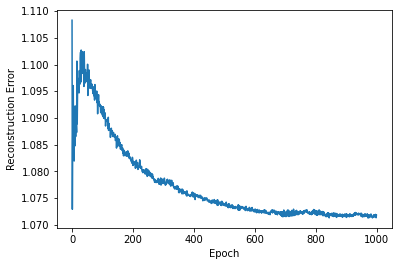

In [93]:
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error");

In [94]:
inputValid = ratings_validation
inputValid = inputValid.astype(np.float32)

_, reconstructedOutput_valid, _ = rbm.rbm_output(inputValid)

In [95]:
predictionsArray = reconstructedOutput_valid
pred_valid = predictionsArray[ratings_validation.nonzero()].flatten()
actual_valid = ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using RBM prediction: {round(rbm_prediction,2)}')

Mean squared error using RBM prediction: 9.33
